# 1) Local linear regression (LOESS)

Here we define a function to perform LOESS regression as a function of 1-dimensional data, a bandwidth parameter, and the number of (evenly spaced) points to predict over.

First define some utility functions, for:

- jitter (random noise)
- array normalization
- point normalization
- computing weights
- band indices

In [40]:
import numpy as np
import scipy.stats as stats

# set random seed
seed = 42
np.random.seed(seed)

def rescale(value, r_min, r_max, t_min=0, t_max=1):
    """
    Scales the value (to the unit interval [0, 1] by default). Strategy referenced from https://stats.stackexchange.com/a/281164/338214.

    :param value: The value to scale
    :param r_min: The minimum of the range the input value is scaled according to
    :param r_max: The maximum of the range the input value is scaled according to
    :param t_min: The minimum of the target range (defaults to 0)
    :param t_max: The maximum of the target range (defaults to 1)
    :return: The rescaled value
    """

    return (value - r_min) / (r_max - r_min) * (t_max - t_min) + t_min

def jitter(x, amount):
    """
    Adds a tunable amount of random noise to the input array. Adapted from https://stackoverflow.com/a/21276920/6514033.

    :param x: The input array
    :param amount: The noise multiplier
    :return:
    """

    sd = .01 * amount * (np.max(x) - np.min(x))
    return x + np.random.randn(len(x)) * sd

def tricubic_weights(x):
    """
    Computes weights for each value of the given array according to a tricubic distribution centered around 0.
    Not used for the final version of this notebook, but included for debugging/comparison.

    :param x: The input array
    :return: The array of weights
    """

    y = np.zeros_like(x)
    i = (x >= -1) & (x <= 1)
    y[i] = np.power(1.0 - np.power(np.abs(x[i]), 3), 3)

    return y

def normal_weights(x, bandwidth):
    """
    Computes weights for each value of the given array according to a normal distribution centered around 0 with standard deviation = bandwidth * standard deviation of the input array

    :param x: The input array
    :return: The array of weights
    """

    mu = 0
    sd = bandwidth * np.std(x)
    x = np.linspace(mu - sd, mu + sd, len(x))
    y = norm.pdf(x, mu, sd)

    return y

def get_band(distances, width):
    """
    Gets the indices of the band of the given width around

    :param distances:
    :param width:
    :return:
    """
    min_i = np.argmin(distances)
    total = len(distances)
    band = [min_i]

    # if the closest neighbor is at either the left or right bound, start the window there
    if min_i == 0: return np.arange(0, width)
    if min_i == total-1: return np.arange(total - width, total)

    # otherwise build it up iteratively
    while len(band) < width:
        min_i = band[0]
        max_i = band[-1]
        if min_i == 0: band.append(max_i + 1)
        elif max_i == total - 1: band.insert(0, min_i - 1)
        elif distances[min_i - 1] < distances[max_i + 1]: band.insert(0, min_i - 1)
        else: band.append(max_i + 1)

    return np.array(band)

def get_weights(distances, band):
    """
    Calculates weights of neighboring (band) points

    :param distances: The array of distances from the current point to all other points
    :param band: The array of indices of the band (neighboring points)
    :return: The weights of the band points
    """

    normed_ds = distances[band] / np.max(distances[band])
    weights = normal_weights(normed_ds, len(band))
    # weights = tricubic_weights(normed_distances

    return weights

# various code inspired by / adapted from:
# - https://github.com/joaofig/pyloess/blob/e6d12ee503fd4f924273f7cb139a10ab4e096752/pyloess/Loess.py
# - https://xavierbourretsicotte.github.io/loess.html

Now define the function to perform LOESS regression.

In [41]:
import pandas as pd
import statsmodels.api as sm

def myloess(dat, bandwidth, num_pts):
    """
    Performs LOESS regression.

    :param dat: The data frame or matrix, with the predictor in the first column and the response in the second
    :param bandwidth: The bandwidth (lambda)
    :param num_pts: The number of points to predict over
    :return: The output matrix, with x values in the first column and predictions in the second
    """

    # extract the predictor and response and compute their respective min and max values
    xs = dat.iloc[:,0]
    x_min = np.min(xs)
    x_max = np.max(xs)

    # extract the response
    ys = dat.iloc[:,1]
    y_min = np.min(ys)
    y_max = np.max(ys)

    # scale the predictor and response to unit interval
    normed_xs = np.interp(xs, (x_min, x_max), (0, 1))
    normed_ys = np.interp(ys, (y_min, y_max), (0, 1))

    # predict n evenly spaced points over the output range
    output_xs = np.linspace(x_min, x_max, num_pts)
    output_ys = []

    for x in output_xs:
        # rescale the value to the unit interval
        normed_x = rescale(x, x_min, x_max)

        # compute distances from this value to all other values
        distances = np.abs(normed_xs - normed_x)

        # get the indices of the band around the current points
        band_is = get_band(distances, bandwidth)

        # get weights for elements of the band
        weights = get_weights(distances, band_is)

        # get the subsets of the normed predictor and response corresponding to the band
        band_xs = normed_xs[band_is]
        band_ys = normed_ys[band_is]

        # fit weighted least squares model to the band
        wls = sm.WLS(band_ys, band_xs, weights=weights)
        wls_results = wls.fit()
        wls_y = wls_results.predict(normed_x)

        output_ys.append(wls_y)

    # rescale the response to the original interval
    output_ys = [y for yy in np.interp(output_ys, (0, 1), (y_min, y_max)) for y in yy]
    return pd.DataFrame({'X': output_xs, 'Y': output_ys})

Generate a sine wave as a simulated dataset to attempt to fit, then test the LOESS function with various levels of noise and bandwidth values.

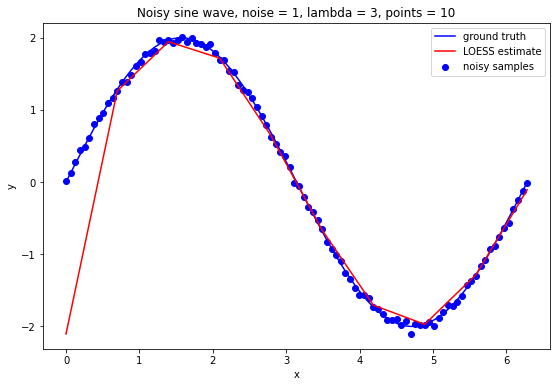

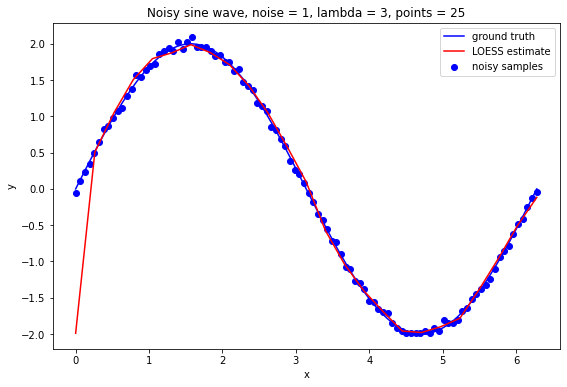

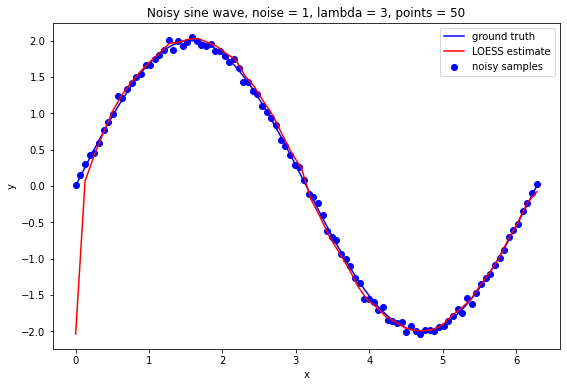

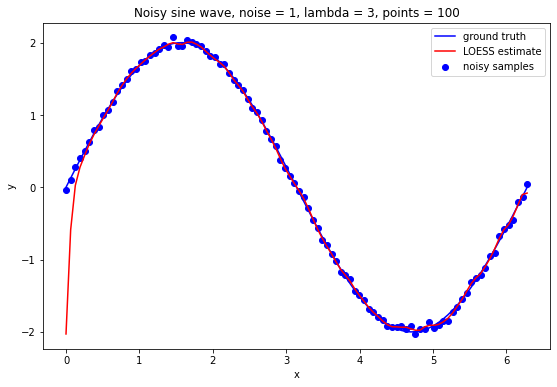

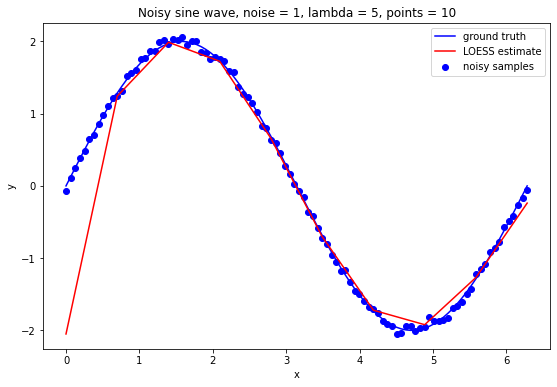

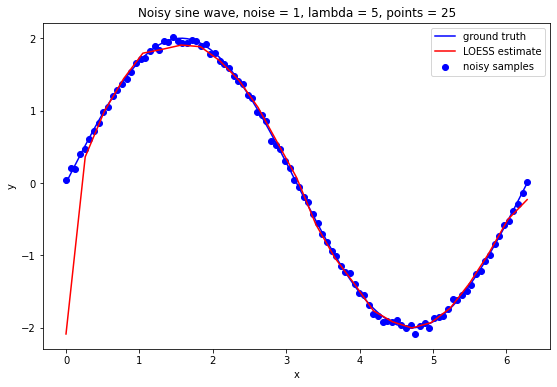

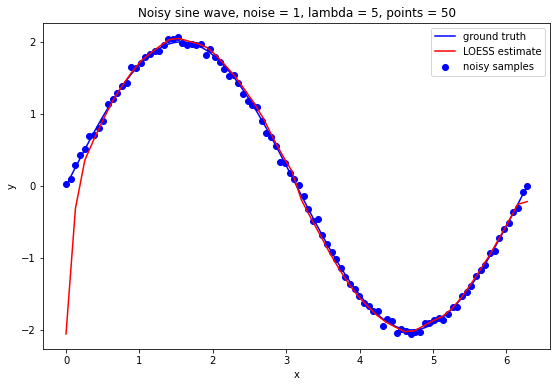

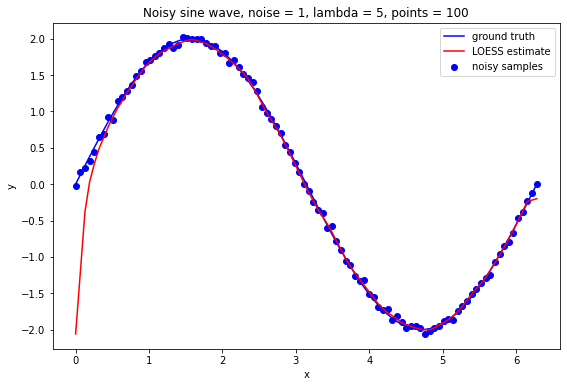

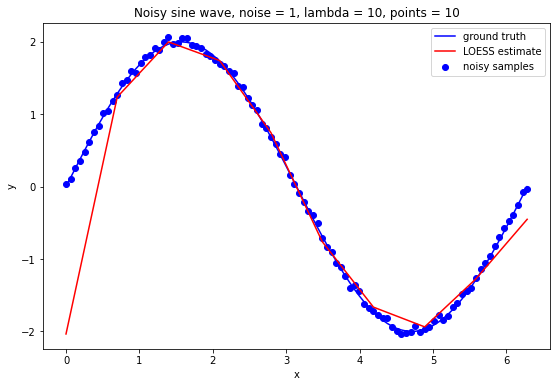

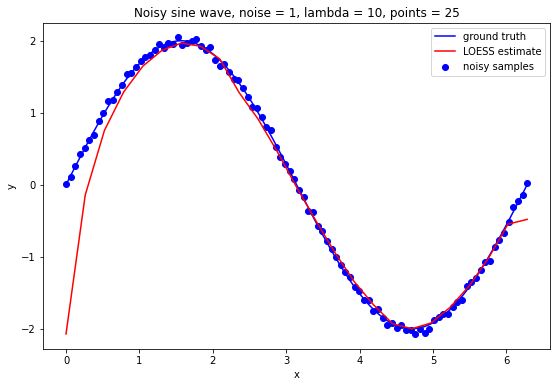

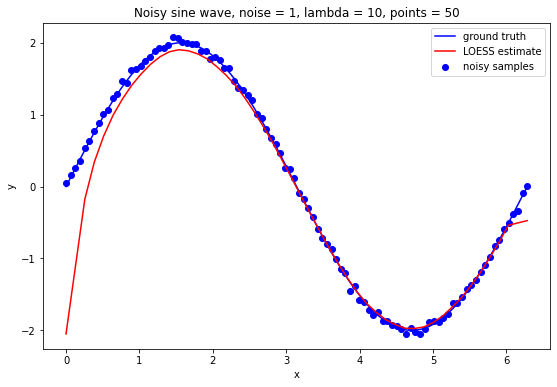

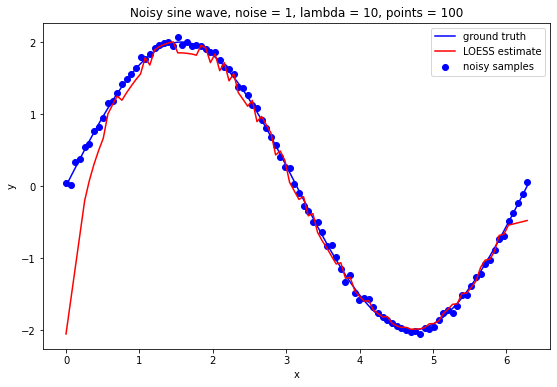

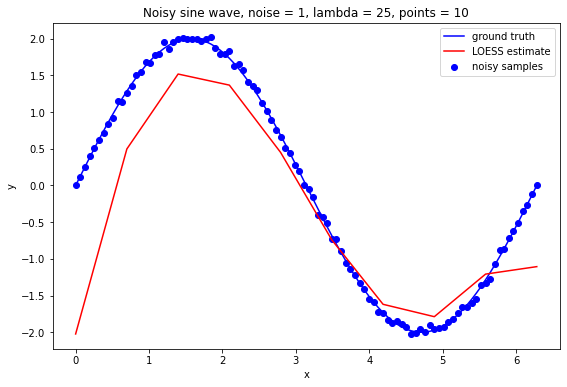

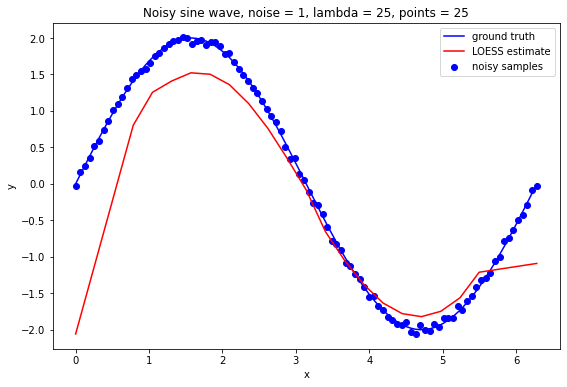

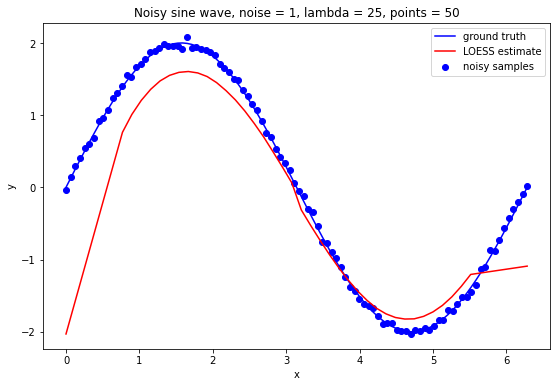

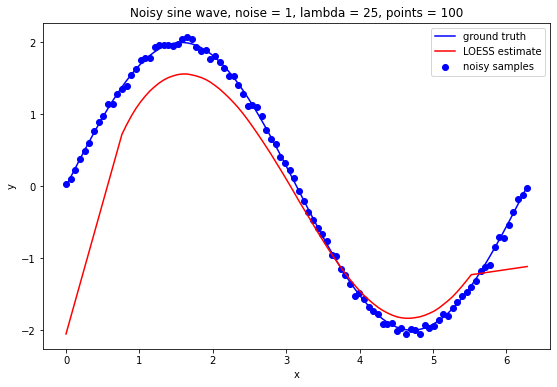

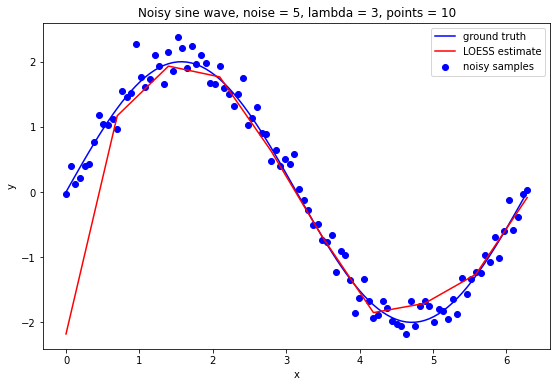

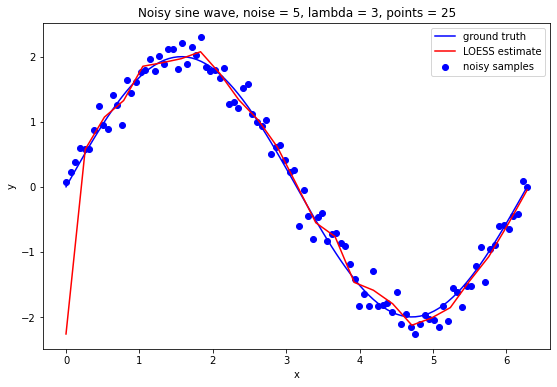

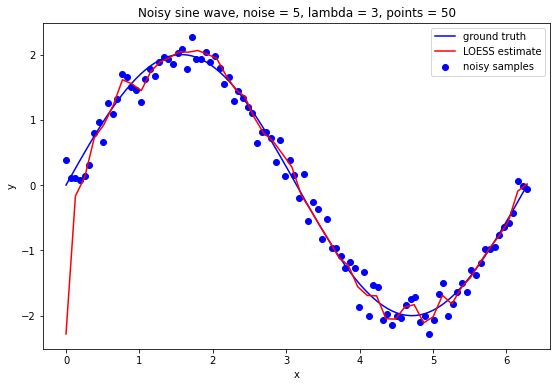

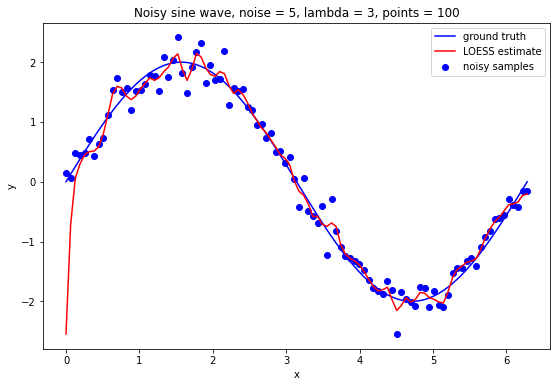

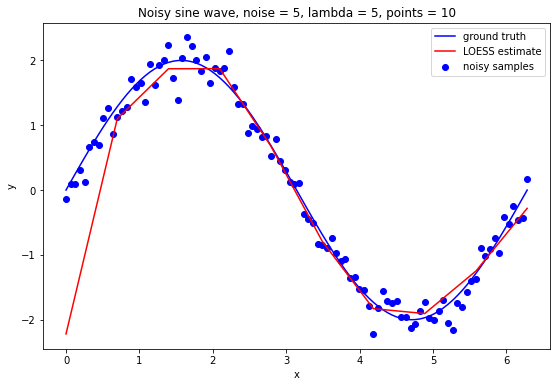

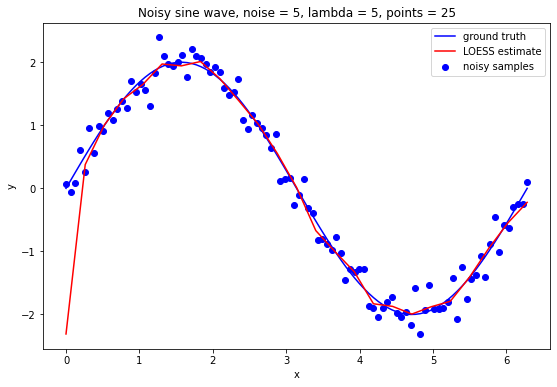

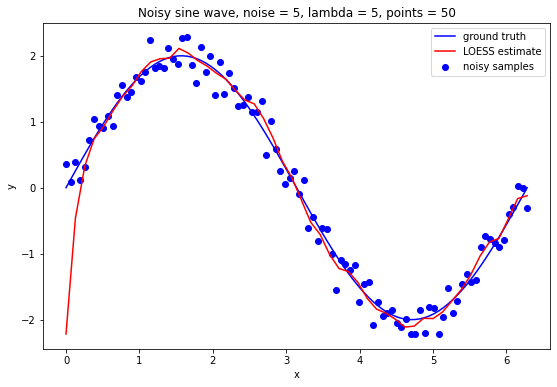

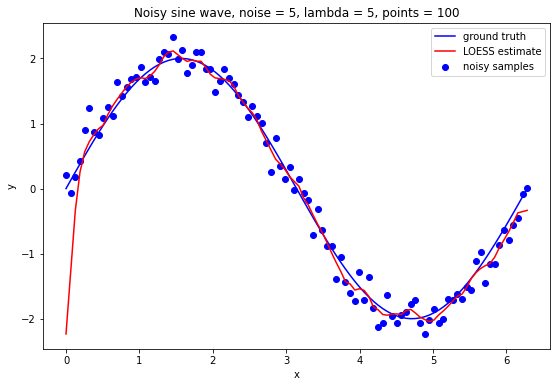

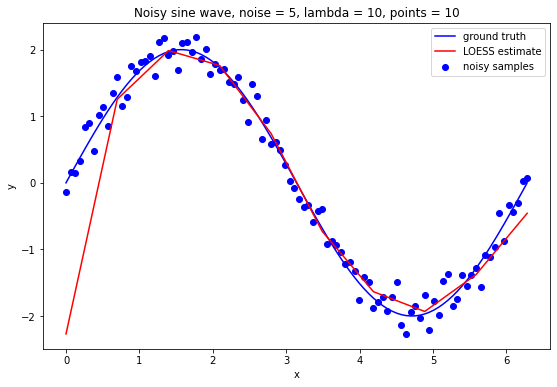

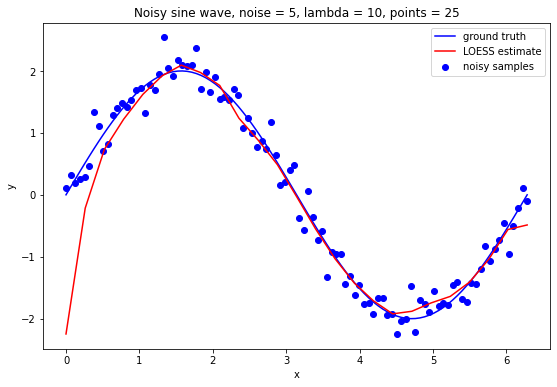

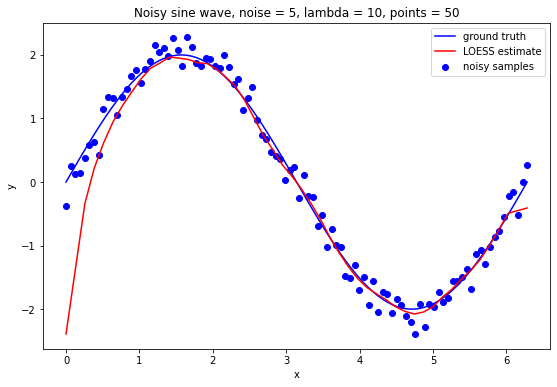

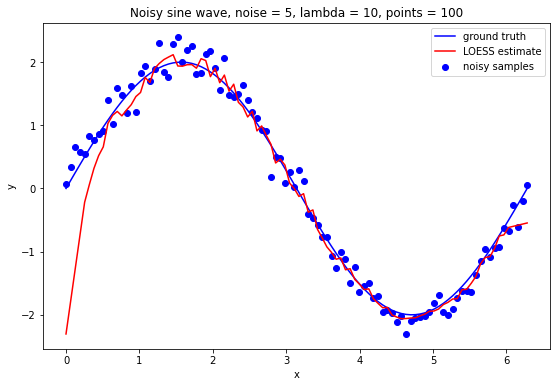

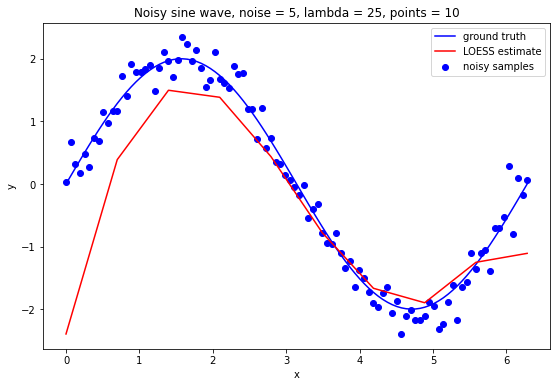

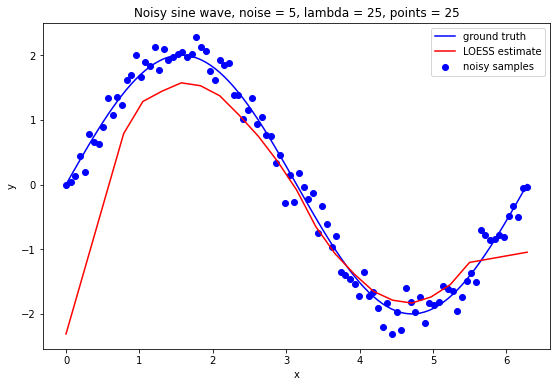

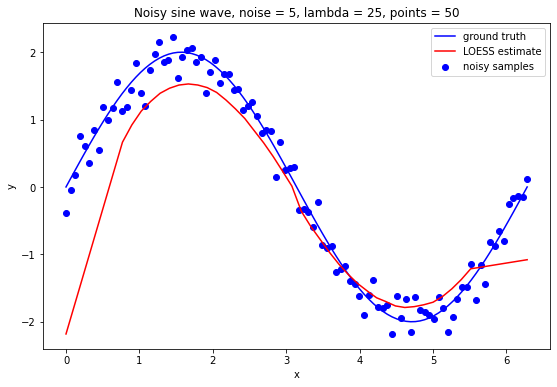

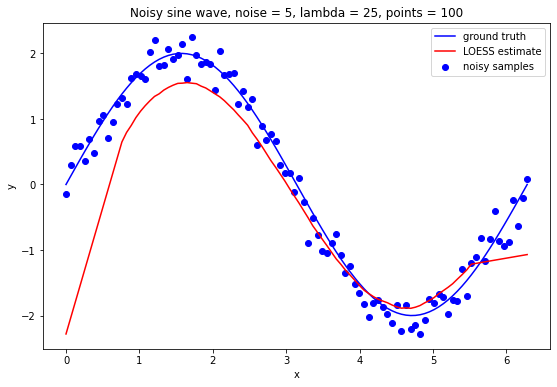

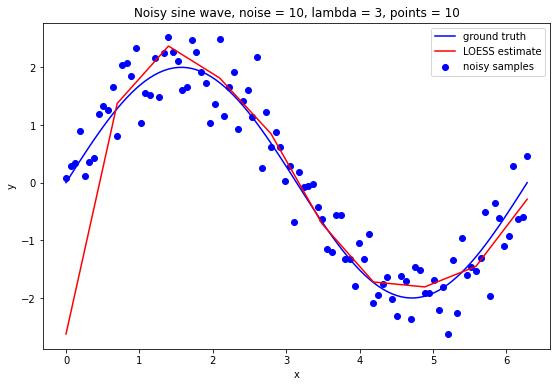

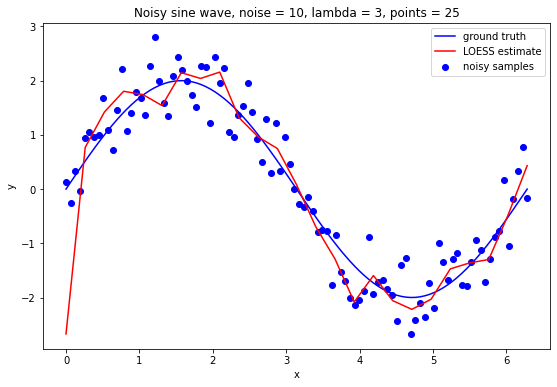

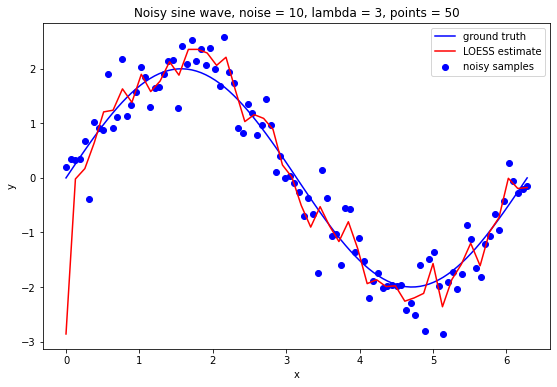

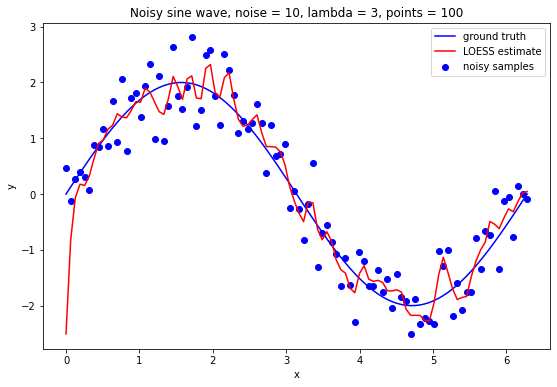

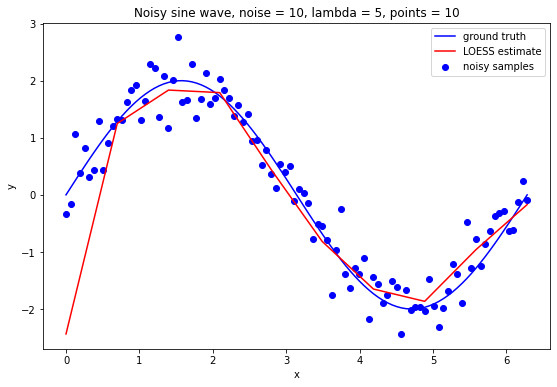

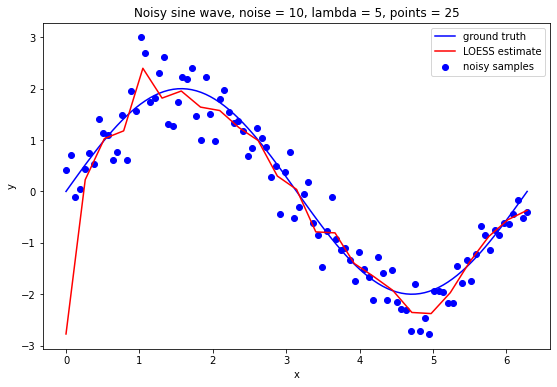

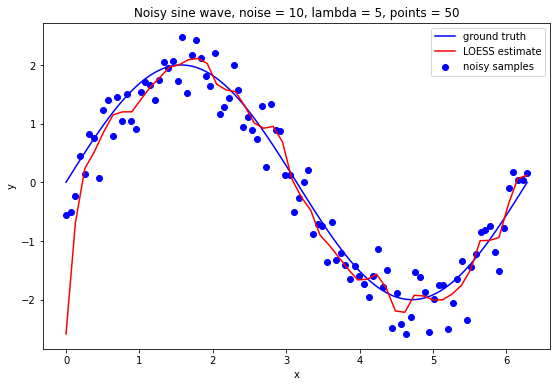

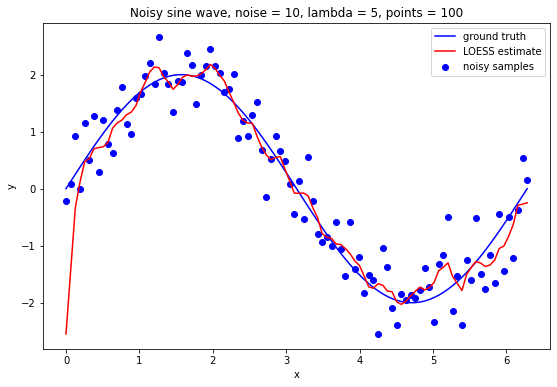

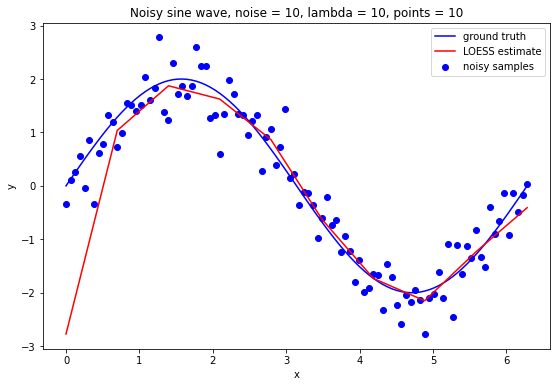

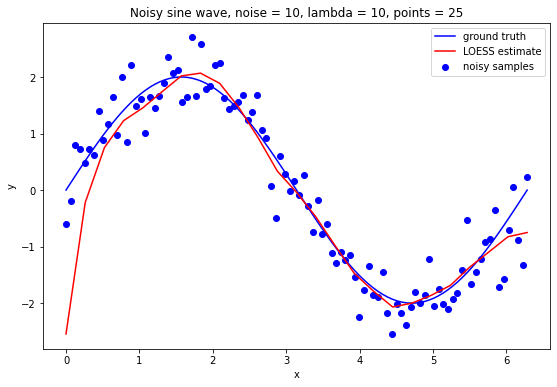

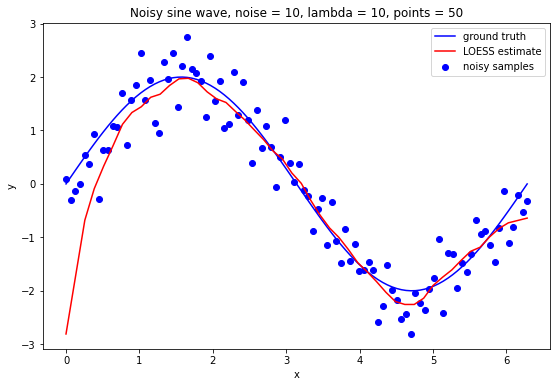

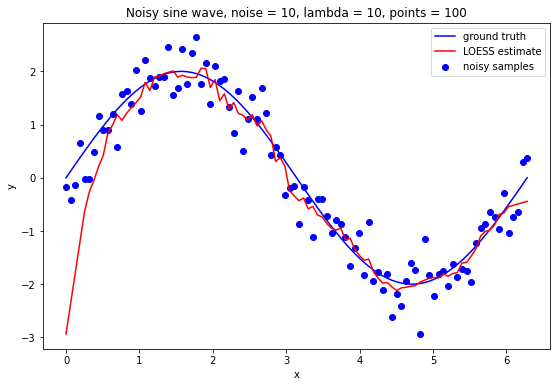

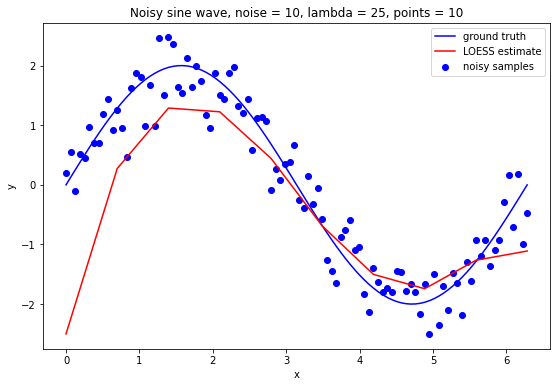

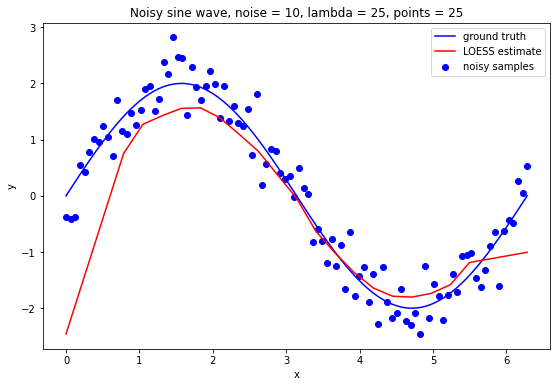

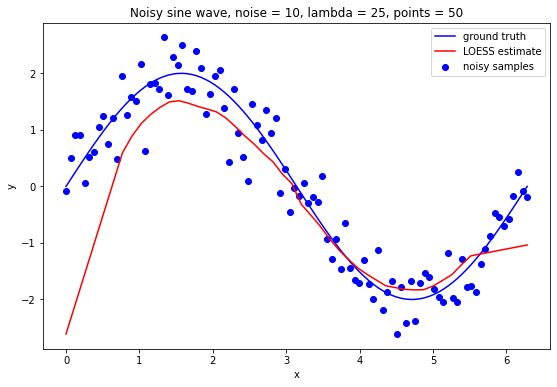

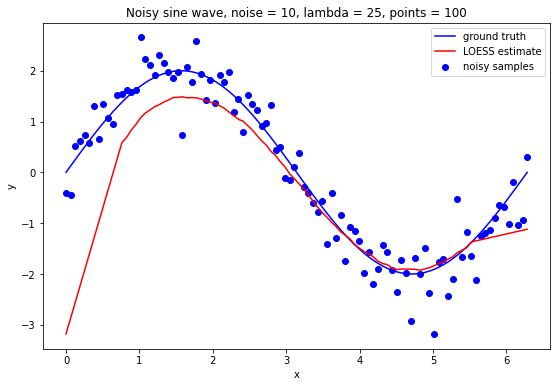

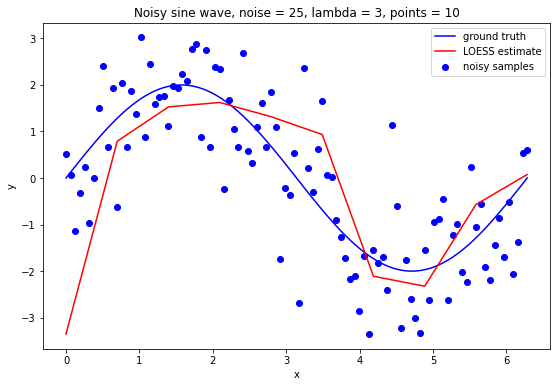

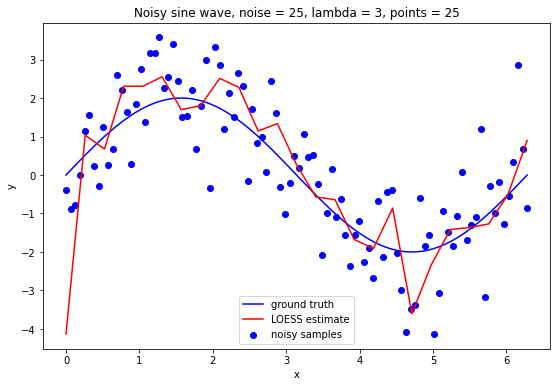

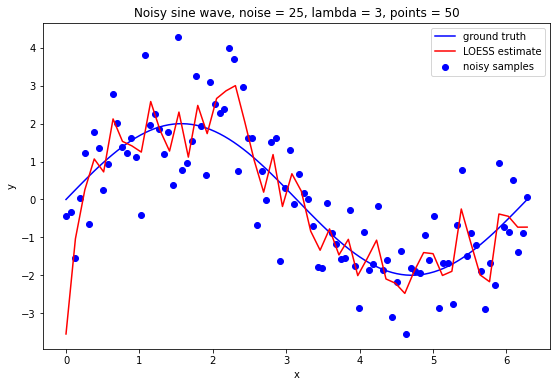

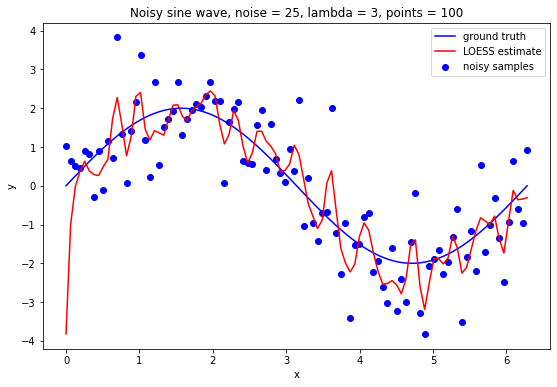

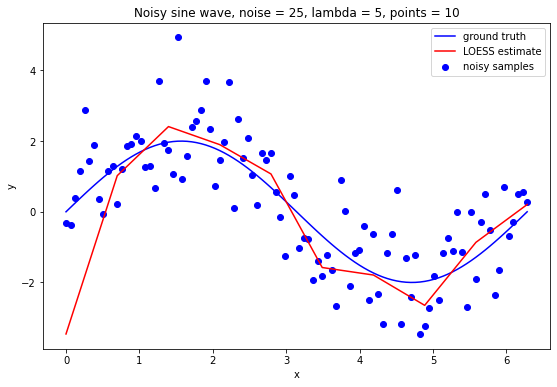

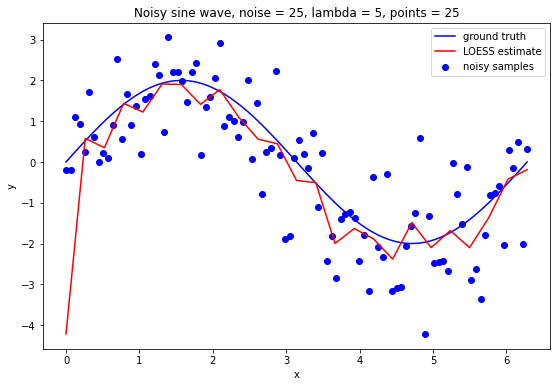

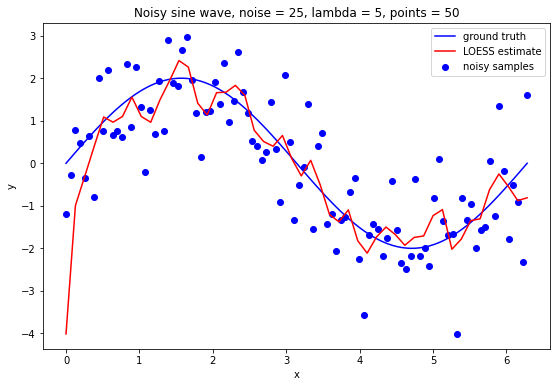

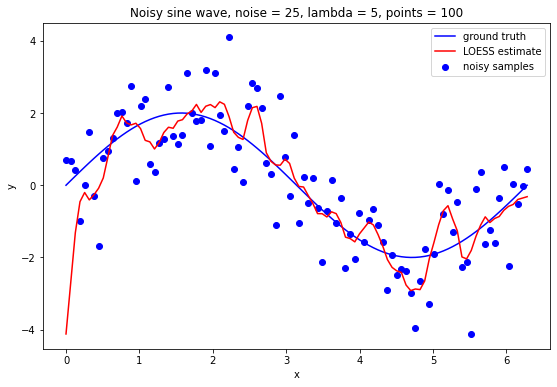

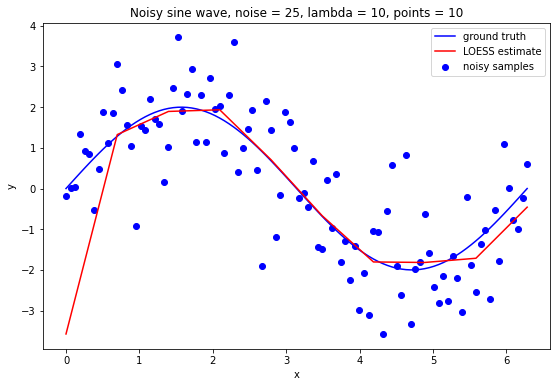

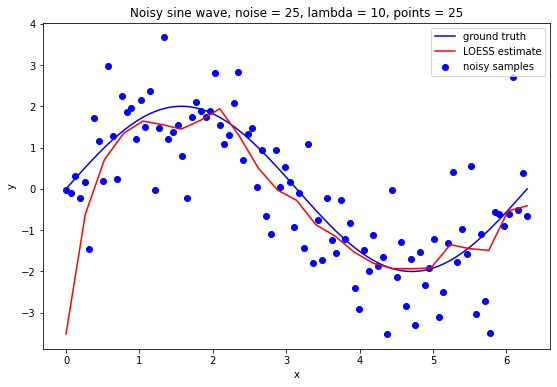

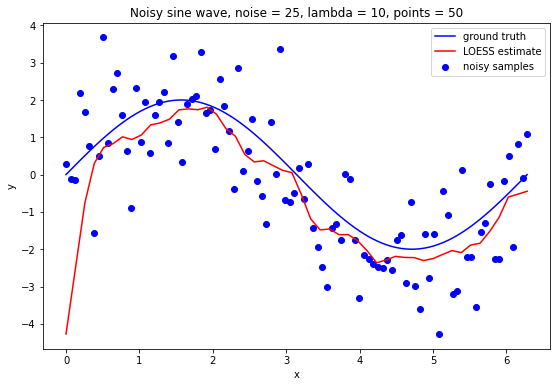

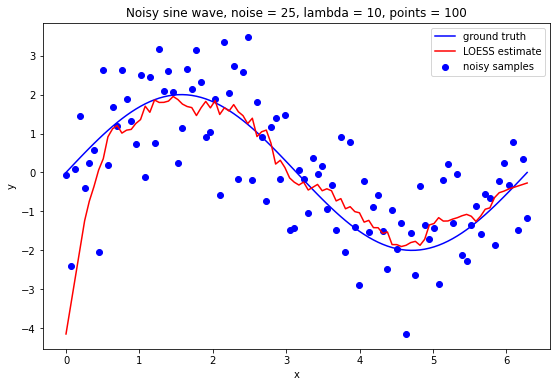

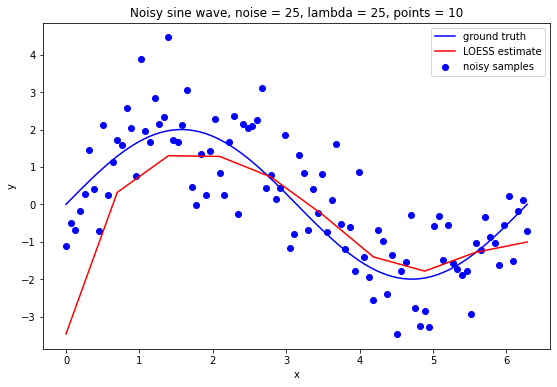

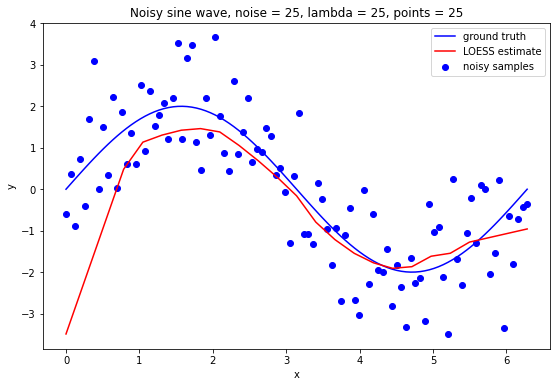

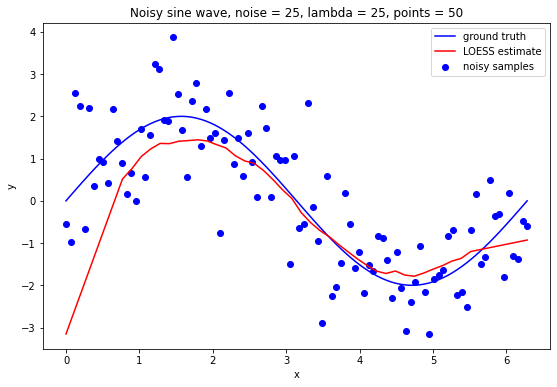

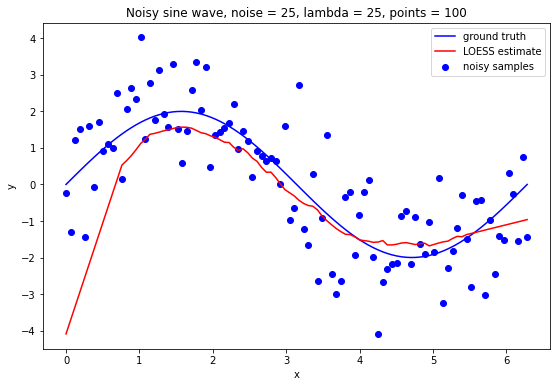

In [42]:
from math import pi
import matplotlib.pyplot as plt

n = 100
x = np.linspace(0, 2 * pi, n)                       # consider 100 evenly spaced points on the interval [0, 2pi]
sine = 2 * np.sin(x)                                # ground truth
noises = [1, 5, 10, 25]                             # different amounts of noise to add to samples
lambdas = [3, 5, 10, 25]                            # different bandwidths to try
points = [int(n / 10), int(n / 4), int(n / 2), n]   # different point counts to try

# try the LOESS function with each combination of noise amount, bandwidth, and number of points
for noise in noises:
    for l in lambdas:
        for pts in points:
            # simulate noisy sampling from the signal
            y = jitter(sine , amount=noise)

            input_df = pd.DataFrame({'X': x, 'Y': y})

            # apply the LOESS function
            output_df = myloess(input_df, l, pts)

            # plot the simulated data
            plt.figure(figsize=(20, 6))
            plt.subplot(121)
            ax = plt.gca()
            ax.plot(x, sine, label='ground truth', color='blue')
            ax.scatter(x, y, label='noisy samples', color='blue')
            ax.plot(output_df.iloc[:, 0], output_df.iloc[:, 1], label='LOESS estimate', color='red')
            ax.legend()
            plt.xlabel("x")
            plt.ylabel("y")
            plt.title(f"Noisy sine wave, noise = {noise}, lambda = {l}, points = {pts}")
            plt.axis("tight")
            plt.show()

Generally, performance suffers due to overfitting when the number of points is high and the bandwidth is low &mash; the slope of the line fitted to each neighborhood varies wildly and the fitted model is not smooth. Performance improves for higher bandwidths, and a point count of about half the length of the original dataset seems to perform well.

# 2) Kernel density estimation

Define kernel density estimation as a function of an input vector $y$, a bandwidth $b$, and a neighborhood width $n$.

First, define some utility functions, for:

- the kernel (normal)

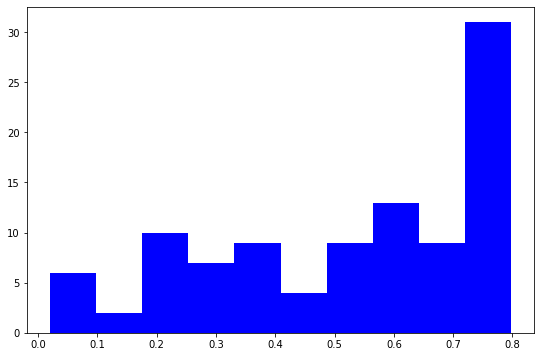

In [52]:
from scipy.special import gamma, factorial2
from scipy.stats import norm

def gauss_integral(n):
    factor = np.sqrt(np.pi * 2)
    if n % 2 == 0:
        return factor * factorial2(n - 1) / 2
    elif n % 2 == 1:
        return factor * norm.pdf(0) * factorial2(n - 1)
    else:
        raise ValueError("n must be odd or even.")

def gaussian(x, dims=1):
    normalization = dims * gauss_integral(dims - 1)
    dist_sq = x ** 2
    return np.exp(-dist_sq / 2) / normalization

x = np.random.normal(0, 1, 100)
y = gaussian(x)

plt.figure(figsize=(20, 6))
plt.subplot(121)
ax = plt.gca()
ax.hist(y, color='blue')
# ax.hist(y, color='blue')
plt.axis("tight")
plt.show()

Define the KDE function.

In [43]:
# inspiration and code from:
# - https://github.com/tommyod/KDEpy
# - https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

def kde(y, bw, n=500):
    """
    Performs kernel density estimation.

    :param y: The sample vector
    :param bw: The bandwidth
    :param n: The number of points to use
    :return:
    """

    pass

Simulate data from various distributions:

- flat
- normal
- bimodal

No handles with labels found to put in legend.


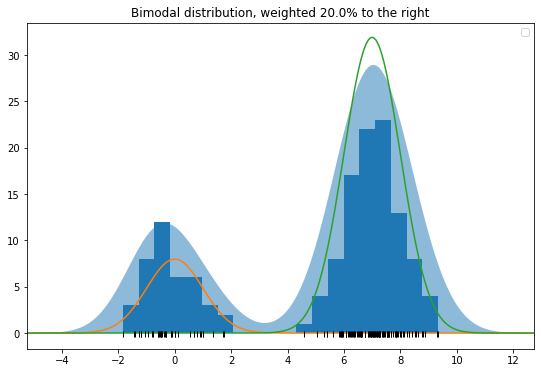

In [162]:
def generate_normal(mu, sd, n):
    """
    Draws random samples from a normal distribution.

    :param mu: The mean
    :param sd: The standard deviation
    :param n: The number of samples to draw
    :return: The array of samples
    """

    return np.random.normal(mu, sd, n)

def generate_bimodal(mu1, mu2, sd1, sd2, n, weight=0.5):
    """
    Draws random samples from a bimodal distribution.

    :param n: The number of samples to draw
    :param weight: The proportion of values per peak (0.5 for half)
    :return: The array of samples
    """

    split = int(n / 2)
    x1 = np.random.normal(mu1, sd1, int(n * weight))
    x2 = np.random.normal(mu2, sd2, n - split)

    return np.concatenate((x1, x2), axis=None)

# define parameters for and generate samples from a bimodal distribution
mu1 = 0
mu2 = 7
sd1 = 1
sd2 = 1
n = 200
w = 0.2

x = generate_bimodal(mu1, mu2, sd1, sd1, n, w)
x_min = np.min(x)
x_max = np.max(x)
x_std = np.std(x)
x_lo = x_min - x_std
x_hi = x_max + x_std
x_range = np.linspace(x_lo, x_hi, n)  # TODO: this n should be the arg to the KDE function
density = sum(norm(xi).pdf(x_range) for xi in x)
dist1 = norm.pdf(x_range, mu1, sd1)  # left peak of bimodal dist
dist2 = norm.pdf(x_range, mu2, sd2)  # right peak of bimodal dist

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.hist(x, bins=20, density=False)
plt.plot(x_range, dist1 * w * n / 2)
plt.plot(x_range, dist2 * (1 - w) * n / 2)
plt.legend()
plt.title(f"Bimodal distribution, weighted {w * 100}% to the right")
plt.xlim([x_lo, x_hi])

plt.fill_between(x_range, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.show()

# x = generate_normal(0, 1, 1000)
# plt.hist(x, bins=40)
# plt.show()